## Import Module and Load Data

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

In [30]:
# Load the provided CSV file
file_path = '/content/Updated_DataFrame_with_Date_Column.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head()

,Username,Profile,date,uptime,datetime
0,taFBL,HARIAN,2024-05-01,17:09:50,2024-05-01 17:09:50
1,tayHw,HARIAN,2024-05-02,23:17:47,2024-05-02 23:17:47
2,taUDL,HARIAN,2024-05-03,20:51:49,2024-05-03 20:51:49
3,taLWw,HARIAN,2024-05-04,23:29:21,2024-05-04 23:29:21
4,taE2U,HARIAN,2024-05-05,22:26:40,2024-05-05 22:26:40


## Data Preprocessing and EDA

In [31]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Aggregate the number of users per day
user_counts_per_day = data.groupby('date').size().reset_index(name='user_count')

# Display the aggregated data
user_counts_per_day

,date,user_count
0,2024-05-01,19
1,2024-05-02,19
2,2024-05-03,19
3,2024-05-04,13
4,2024-05-05,13
5,2024-05-06,19
6,2024-05-07,19
7,2024-05-08,19
8,2024-05-09,18
9,2024-05-10,18


In [32]:
# Convert 'datetime' column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the date and hour from the datetime
data['date'] = data['datetime'].dt.date
data['hour'] = data['datetime'].dt.hour

# Aggregate data to get the number of users per hour
user_count_per_hour = data.groupby(['date', 'hour']).size().reset_index(name='user_count')

# Pivot the data to have hours as columns and dates as rows
pivot_data = user_count_per_hour.pivot(index='date', columns='hour', values='user_count').fillna(0)

# Display the first few rows of the aggregated data
print(user_count_per_hour.head())

         date  hour  user_count
0  2024-05-01    10           1
1  2024-05-01    11           1
2  2024-05-01    12           2
3  2024-05-01    13           1
4  2024-05-01    16           1


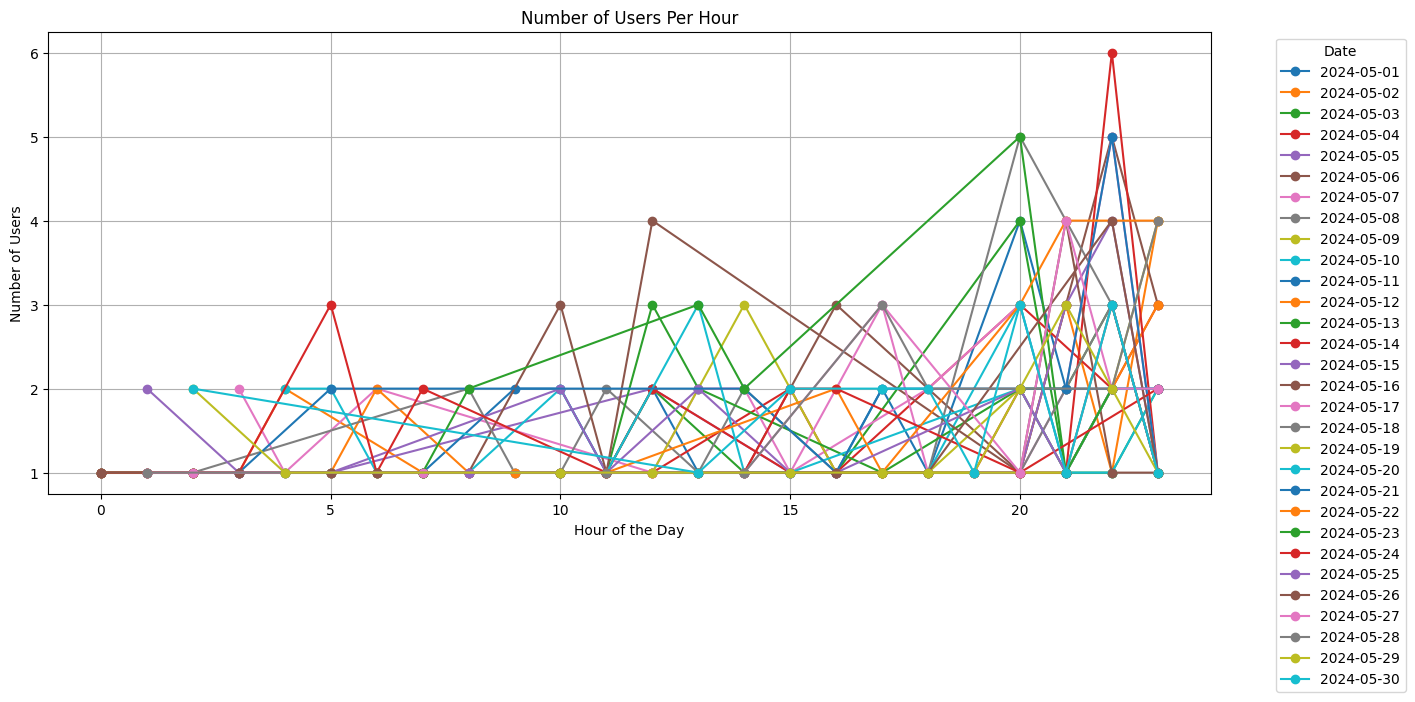

In [33]:
# Plot the number of users per hour
plt.figure(figsize=(15, 6))
for single_date in user_count_per_hour['date'].unique():
    daily_data = user_count_per_hour[user_count_per_hour['date'] == single_date]
    plt.plot(daily_data['hour'], daily_data['user_count'], marker='o', label=single_date)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.title('Number of Users Per Hour')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Time Series Forecasting

## LSTM Model

### Preparing the Data for Training

In [34]:
# Convert the pivoted data to a NumPy array
data_array = pivot_data.to_numpy()

# Split the data into training and testing sets
train_size = int(len(data_array) * 0.8)
train_data = data_array[:train_size]
test_data = data_array[train_size:]

# Normalize the data
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

### Prepare the Data

In [35]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

### Building the LSTM Model

In [36]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [37]:
model.fit(X_train, y_train, batch_size=1, epochs=128, validation_data=(X_test, y_test))

Epoch 1/128
22/22 [==============================] - 0s 9ms/step - loss: 0.0043 - accuracy: 0.9545 - val_loss: 1.6432 - val_accuracy: 0.2500
Epoch 2/128
22/22 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.9091 - val_loss: 1.6365 - val_accuracy: 0.2500
Epoch 3/128
22/22 [==============================] - 0s 6ms/step - loss: 0.0055 - accuracy: 0.9545 - val_loss: 1.6454 - val_accuracy: 0.2500
Epoch 4/128
22/22 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 0.9545 - val_loss: 1.6370 - val_accuracy: 0.2500
Epoch 5/128
22/22 [==============================] - 0s 6ms/step - loss: 0.0043 - accuracy: 0.9545 - val_loss: 1.6463 - val_accuracy: 0.2500
Epoch 6/128
22/22 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 0.9545 - val_loss: 1.6305 - val_accuracy: 0.2500
Epoch 7/128
22/22 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.9091 - val_loss: 1.6299 - val_accuracy: 0.2500
Epoch 8/128
2

In [38]:
model.save('lstm_user_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Make Predictions

Enter the date you want to predict the number of users (YYYY-MM-DD): 2024-05-21
1/1 [==============================] - 1s 851ms/step
Predicted number of users for 2024-05-21:
Hour 0: 0.02 users
Hour 1: -0.03 users
Hour 2: 0.00 users
Hour 3: 0.99 users
Hour 4: 0.00 users
Hour 5: 1.97 users
Hour 6: 0.01 users
Hour 7: 0.00 users
Hour 8: 0.00 users
Hour 9: 0.02 users
Hour 10: 0.04 users
Hour 11: 0.03 users
Hour 12: -0.02 users
Hour 13: 0.04 users
Hour 14: 2.02 users
Hour 15: 0.02 users
Hour 16: 0.96 users
Hour 17: 1.98 users
Hour 18: 0.02 users
Hour 19: 0.01 users
Hour 20: 2.06 users
Hour 21: 1.90 users
Hour 22: 4.94 users
Hour 23: 0.98 users
Total number of users for 2024-05-21: 17.97 users


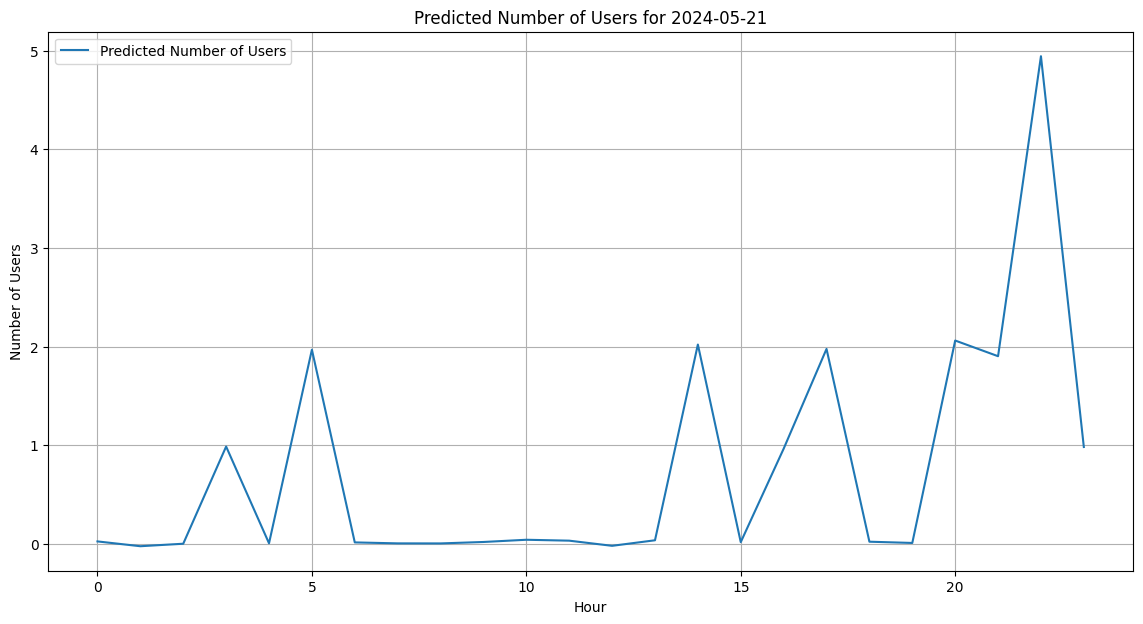

In [46]:
# Load the trained LSTM model
model = load_model('lstm_user_prediction_model.h5')

# Function to prepare the input sequence for a given date
def prepare_input_sequence(data, date, time_step, mean, std):
    date = pd.to_datetime(date).date()
    date_idx = (pivot_data.index.get_loc(date) if date in pivot_data.index else len(pivot_data)-1)
    input_sequence = pivot_data.iloc[date_idx-time_step:date_idx].values
    input_sequence = (input_sequence - mean) / std
    return input_sequence.reshape(1, time_step, input_sequence.shape[1])

# Function to predict the number of users for a specific date
def predict_for_date(date, model, pivot_data, time_step, mean, std):
    input_sequence = prepare_input_sequence(pivot_data, date, time_step, mean, std)
    next_day_predict = model.predict(input_sequence)
    next_day_predict = next_day_predict * std + mean
    return next_day_predict

# User input for the date
user_input_date = input("Enter the date you want to predict the number of users (YYYY-MM-DD): ")

# Ensure the date is valid
try:
    datetime.strptime(user_input_date, '%Y-%m-%d')
except ValueError:
    print("Incorrect date format. Please enter the date in YYYY-MM-DD format.")
    user_input_date = '2023-06-13'  # Default date if the input is invalid

# Predict the number of users for the given date
predicted_users = predict_for_date(user_input_date, model, pivot_data, time_step, mean, std)

# Print the number of users for each hour and the total number of users for that day
total_users = np.sum(predicted_users)
print(f'Predicted number of users for {user_input_date}:')
for hour in range(24):
    print(f'Hour {hour}: {predicted_users[0][hour]:.2f} users')

print(f'Total number of users for {user_input_date}: {total_users:.2f} users')

# Plot the prediction results for the user-specified date
plt.figure(figsize=(14, 7))
plt.plot(range(24), predicted_users[0], label='Predicted Number of Users')
plt.title(f'Predicted Number of Users for {user_input_date}')
plt.xlabel('Hour')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to get actual values
train_predict = train_predict * std + mean
test_predict = test_predict * std + mean

# Predict for the next day (Tuesday)
last_day = data_array[-1].reshape(1, 1, data_array.shape[1])
next_day_predict = model.predict(last_day)
next_day_predict = next_day_predict * std + mean

next_day_predict

1/1 [==============================] - 0s 23ms/step


array([[ 0.21642671,  0.31583802,  0.51299594,  0.41206681,  0.42106674,
         0.37322644, -0.03220793,  0.79559326,  0.74593865,  0.27419247,
         1.12023417,  0.64229405,  1.35645084,  0.46617731,  0.31631675,
         0.78990274,  0.26570089,  0.42932536,  0.3325728 ,  0.35139298,
         2.32661244,  1.99113827,  1.47652828,  1.78953877]])

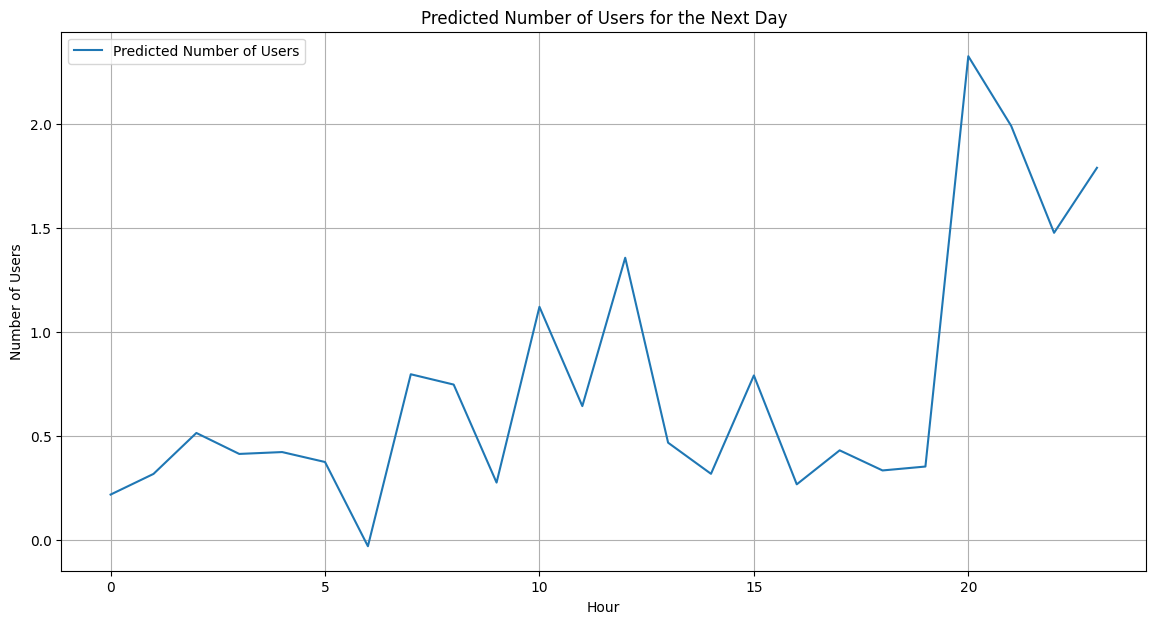

In [ ]:
# Plot the prediction results for the next day
plt.figure(figsize=(14, 7))
plt.plot(range(24), next_day_predict[0], label='Predicted Number of Users')
plt.title('Predicted Number of Users for the Next Day')
plt.xlabel('Hour')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(True)
plt.show()

## Linear Regression Model

In [ ]:
# Prepare the data for linear regression
user_counts_per_day['day'] = (user_counts_per_day['date'] - user_counts_per_day['date'].min()).dt.days
X = user_counts_per_day['day'].values.reshape(-1, 1)
y = user_counts_per_day['user_count'].values

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

    hour  predicted_user_count
0      0              0.018784
1      1              0.038543
2      2              0.074293
3      3              0.134528
4      4              0.228840
5      5              0.365685
6      6              0.548958
7      7              0.774155
8      8              1.025588
9      9              1.276365
10    10              1.492222
11    11              1.638886
12    12              1.690910
13    13              1.638886
14    14              1.492222
15    15              1.276365
16    16              1.025588
17    17              0.774155
18    18              0.548958
19    19              0.365685
20    20              0.228840
21    21              0.134528
22    22              0.074293
23    23              0.038543
The predicted number of users for 2024-05-11 is 16.91


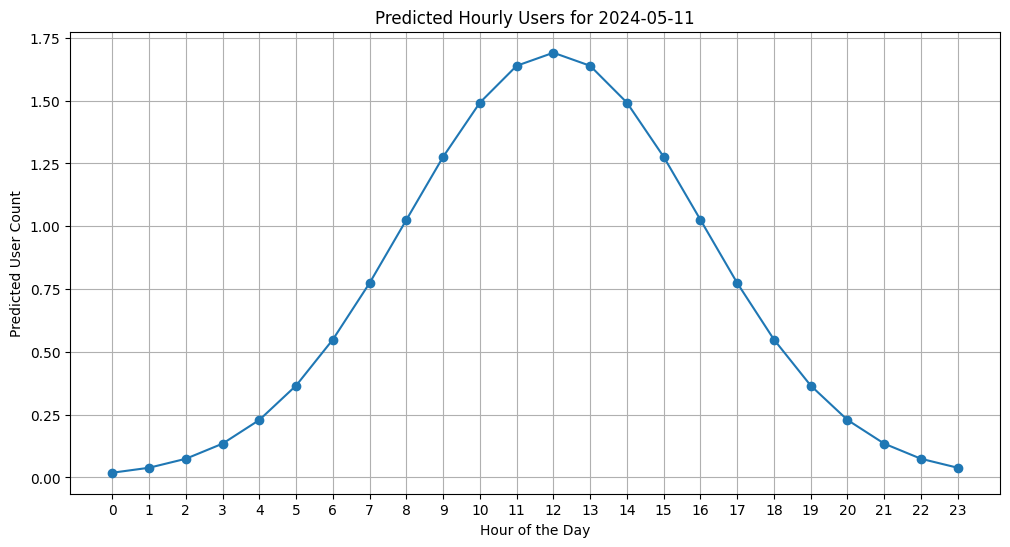

In [ ]:
def predict_hourly_users_for_date(input_date: str) -> pd.DataFrame:
    # Get the predicted number of users for the given date
    predicted_users_day = predict_users_for_date(input_date)

    # Generate hourly distribution assuming a normal distribution centered around midday
    hours = np.arange(24)
    mean_hour = 12  # Center around midday
    std_dev = 4     # Standard deviation, adjust as needed
    hourly_distribution = np.exp(-0.5 * ((hours - mean_hour) / std_dev) ** 2)
    hourly_distribution /= hourly_distribution.sum()  # Normalize to sum to 1

    # Calculate the number of users for each hour
    hourly_users = predicted_users_day * hourly_distribution

    # Create a DataFrame for the result
    hourly_df = pd.DataFrame({
        'hour': hours,
        'predicted_user_count': hourly_users
    })

    return hourly_df

def predict_users_for_date(input_date: str) -> float:
    # Convert input date to datetime object
    input_date_dt = pd.to_datetime(input_date)

    # Calculate the 'day' value for the input date
    days_since_start = (input_date_dt - user_counts_per_day['date'].min()).days

    # Prepare the input for prediction
    input_day = np.array([[days_since_start]])

    # Predict the number of users
    predicted_user_count = model.predict(input_day)

    return predicted_user_count[0]

def plot_hourly_users_for_date(input_date: str):
    # Get the predicted hourly users for the given date
    hourly_users_df = predict_hourly_users_for_date(input_date)

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_users_df['hour'], hourly_users_df['predicted_user_count'], marker='o', linestyle='-')
    plt.title(f'Predicted Hourly Users for {input_date}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Predicted User Count')
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.show()

desired_date = '2024-05-11'  # Change this to the date you want to predict

predicted_hourly_users = predict_hourly_users_for_date(desired_date)
print(predicted_hourly_users)

predicted_users = predict_users_for_date(desired_date)
print(f"The predicted number of users for {desired_date} is {predicted_users:.2f}")

plot_hourly_users_for_date(desired_date)

In [ ]:
# Save the linear regression model
regression_model_path = 'linear_regression_user_prediction_model.pkl'
joblib.dump(model, regression_model_path)
print(f"Model saved to {regression_model_path}")

Model saved to linear_regression_user_prediction_model.pkl
